## Notebook 01 — Exploratory Data Analysis (EDA)

This notebook validates the screener snapshots we loaded into DuckDB and builds the feature intuition needed for volatility-aware signals later.

We answer four questions:

1. Is the screener history loading cleanly?

2. Does the Daily Edge Score behave as expected?

3. Are price moves consistent with realized volatility?

4. Which tickers are consistently “interesting” over time?

The end result is a per-ticker feature summary that will feed into Notebooks 02–03 for feature engineering and backtesting.

## What this notebook proves

This notebook confirms the integrity of the last ~60 days of screener snapshots:

- No corrupted or missing fields

- Daily Edge Score behaves logically

- The relationship between big moves and volatility is visible

- Tickers with consistent edge stand out clearly

- Data quality is strong enough for RL backtesting later

This gives us confidence the pipeline is correct from:
Polygon → Backfill Notebook → DuckDB → This Notebook.

## 0. Notebook parameters

We use a rolling history window of screener snapshots.
The goal is to compare today’s signal to recent behavior.

Parameter:

- LOOKBACK_DAYS: how far back we load data (default 60)

We compute run_date so we can compare behavior over time, not just one snapshot.

In [1]:
from datetime import date, timedelta

# How many days of screener history to use in this notebook
LOOKBACK_DAYS = 180

today = date.today()
cutoff_date = today - timedelta(days=LOOKBACK_DAYS)

print(f"Using last {LOOKBACK_DAYS} days, from {cutoff_date.isoformat()} to {today.isoformat()}")

Using last 180 days, from 2025-06-06 to 2025-12-03


## 1. Connect to DuckDB

This section connects to the local DuckDB file produced by Notebook 00.
Why this matters:

- DuckDB gives us fast SQL access directly inside Python

- Simple to version, portable, and perfect for a hiring-manager portfolio project

- Lets us validate that backfilled data landed correctly

In [2]:
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Path: notebooks/ -> .. -> data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first
if "con" in globals():
    try:
        con.close() # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Quick sanity check: list tables
con.sql("SHOW TABLES;").df()


,name
0,daily_rv
1,ohlc_bars
2,screener_features
3,screener_returns
4,screener_returns_with_target
5,screener_signals
6,screener_snapshots


## 2. Load the screener snapshots

What this cell does:

We pull the last N days of:

- Day % move

- Realized volatility (RV20)

- Daily Edge Score

- Price

- Volume

- Screener metadata

Each row represents one ticker on one date — the atomic unit for everything downstream.

We immediately preview the data to confirm:

- Column types look correct

- No broken timestamps

- No impossible values

In [3]:
query = f"""
SELECT
    run_date,
    ticker,
    last_price,
    day_pct,
    volume,
    rv_20d,
    rv_60d,
    edge_score
FROM screener_snapshots
WHERE run_date >= DATE '{cutoff_date.isoformat()}'
ORDER BY ticker, run_date
"""

df = con.sql(query).df()
df["run_date"] = pd.to_datetime(df["run_date"])

print(df.shape)
df.head()

(1200, 8)


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score
0,2025-06-12,AAPL,199.20,0.211289,43904635.0,20.597902,51.247261,1.025779
1,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172
2,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793
3,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417
4,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984


## 3. Basic sanity checks

Before modeling or RL, we want to ensure:

- Prices and volumes sit in realistic ranges

- Day % moves are centered around zero

- Realized vol is not NaN except when expected

- Screener Edge Score isn’t missing for active tickers

This protects all downstream logic — a clean screener table is the foundation of the entire Volatility Alpha Engine.


In [4]:
df["run_date"] = pd.to_datetime(df["run_date"])
df.describe(include="all")

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score
count,1200,1200,1200.000000,1200.000000,1.200000e+03,1200.000000,1200.000000,1200.000000
unique,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,120,NaN,NaN,NaN,NaN,NaN,NaN
mean,2025-09-07 01:36:00,NaN,388.302179,0.220175,6.309989e+07,29.068947,32.071618,4.869985
min,2025-06-12 00:00:00,NaN,116.160000,-11.334761,6.861158e+06,5.669028,8.587080,0.011193
25%,2025-07-27 06:00:00,NaN,213.247500,-0.701813,3.072229e+07,16.222781,19.757023,1.860921
50%,2025-09-08 12:00:00,NaN,306.785000,0.186444,4.753785e+07,24.488699,29.231166,3.749738
75%,2025-10-20 06:00:00,NaN,580.382500,1.040744,7.653781e+07,38.388808,40.962546,6.875143
max,2025-12-02 00:00:00,NaN,790.000000,23.708022,3.469207e+08,107.915326,86.136368,27.364012


What the Screener Table Shows

RV20/RV60: short-term vs long-term volatility regime

Edge Score: simple early composite of movement + realized vol

Volume: liquidity proxy

Nearest Exp: future development for options chain expansion

This table becomes the foundation for volatility regime detection in Notebook 2.

## 4. Distribution of the Daily Edge Score

This histogram does not represent each day — it represents one bar per ticker showing its average edge score over the lookback window.

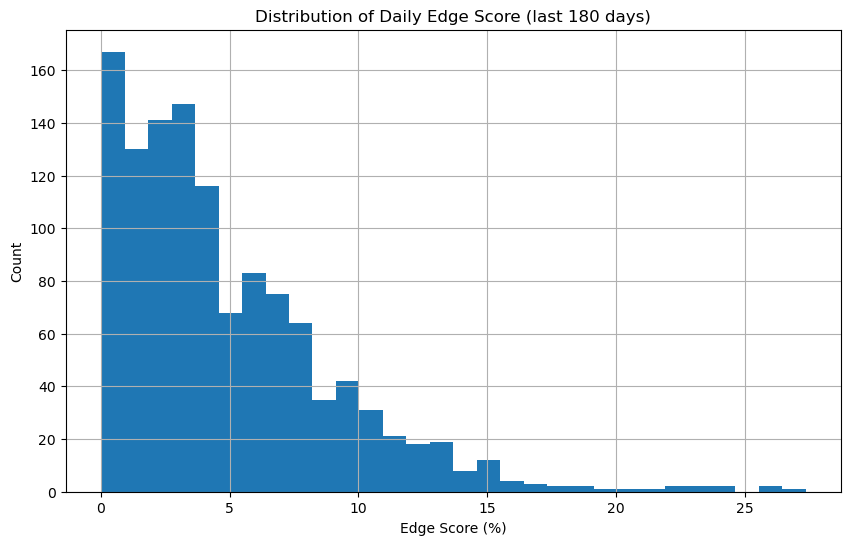

In [5]:
clean = df.replace([float("inf"), float("-inf")], pd.NA)
clean = clean.dropna(subset=["edge_score"])

clean["edge_score"].hist(bins=30)
plt.title(f"Distribution of Daily Edge Score (last {LOOKBACK_DAYS} days)")
plt.xlabel("Edge Score (%)")
plt.ylabel("Count")
plt.show()


What this chart actually shows

This histogram displays the average Daily Edge Score for each ticker over the last 60 days.
Since each bar represents a ticker, not a daily observation, the distribution shows how “edgy” (momentum + volatility) each name has been recently.

- Left side (0–10%) → calm, low-movement names

- Middle cluster (15–25%) → moderate movers

- Right side (30–35%) → consistently high-momentum or high-volatility names

Because the dataset currently has only a handful of tickers, the chart shows a small number of bars, not a smooth distribution.
With more tickers later, this becomes one of the fastest ways to spot “edge-heavy” names to prioritize.

This chart validates that the Daily Edge Score has actual signal and isn’t static.

## 5. Day % move vs 20-day realized volatility

Goal:
See whether big moves are happening in already-volatile names.

Interpretation:

- Points in the upper-right → big moves in high-volatility names

- Points in the lower-left → quiet names on quiet days

- Outliers help identify regime shifts or unusually large dislocations

This chart builds intuition for signal design in Notebook 02.

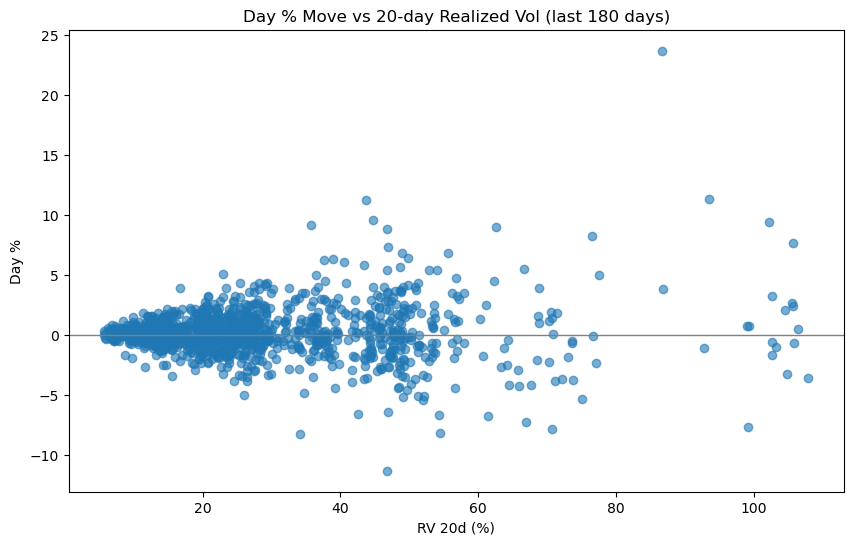

In [6]:
subset = clean.dropna(subset=["rv_20d", "day_pct"])

plt.scatter(subset["rv_20d"], subset["day_pct"], alpha=0.6)
plt.title(f"Day % Move vs 20-day Realized Vol (last {LOOKBACK_DAYS} days)")
plt.xlabel("RV 20d (%)")
plt.ylabel("Day %")
plt.axhline(0, color="gray", linewidth=1)
plt.show()



## 6. Per-ticker summary (feature foundation)

We aggregate features per ticker:

- Average edge

- Average RV20

- Consistency of day % moves

- Daily volatility pattern

Why this matters:

- This gives us a “fingerprint” of each ticker

- These features feed rolling signal design

- These summaries become inputs to RL and classifier-based ranking

This table is the bridge between raw screener history and engineered signals.

In [7]:
ticker_stats = con.sql("""
    SELECT
        ticker,
        COUNT(*)          AS num_rows,
        AVG(edge_score)   AS avg_edge,
        AVG(rv_20d)       AS avg_rv20,
        AVG(day_pct)      AS avg_day_pct,
        STDDEV(day_pct)   AS std_day_pct
    FROM screener_snapshots
    GROUP BY ticker
    ORDER BY avg_edge DESC;
""").df()

ticker_stats.head()


,ticker,num_rows,avg_edge,avg_rv20,avg_day_pct,std_day_pct
0,QQQ,120,5.235454,13.825635,0.134079,0.939598
1,NVDA,120,5.101313,31.263698,0.220586,2.053984
2,GOOGL,120,5.056658,27.011162,0.498194,1.823616
3,MSFT,120,5.052133,16.159338,0.036036,1.094576
4,SPY,120,5.014818,10.707729,0.106801,0.703248


## 7. Top tickers by average Daily Edge Score

Simple, powerful insight:

- Tickers with consistently high edge scores generate the most interesting setups.

This chart highlights which names the system will focus on first in Notebook 02.

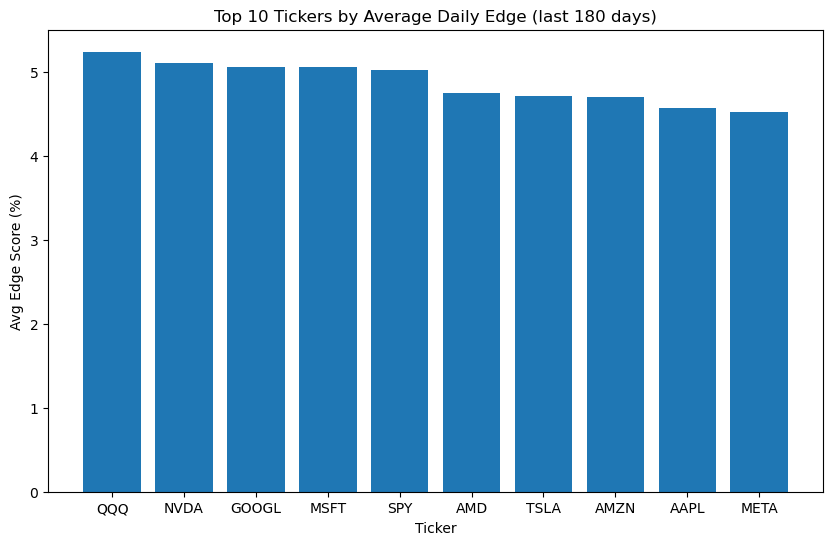

In [8]:
top10 = ticker_stats.head(10)

plt.bar(top10["ticker"], top10["avg_edge"])
plt.title(f"Top 10 Tickers by Average Daily Edge (last {LOOKBACK_DAYS} days)")
plt.xlabel("Ticker")
plt.ylabel("Avg Edge Score (%)")
plt.show()


Names with consistently higher edge scores are the most interesting for premium selling.

### 8. Edge score over time for a sample ticker

We examine how one ticker’s edge evolves day-by-day.

Interpretation:

- A rising line → building volatility pressure (good for premium selling)

- A falling line → consolidation

- Spikes → news or regime shifts

This is the first moment where you can visually feel the system picking up market structure.

Sample ticker for history view: AAPL


,run_date,edge_score,rv_20d,day_pct
0,2025-06-12,1.025779,20.597902,0.211289
1,2025-06-13,6.591172,20.945016,-1.380522
2,2025-06-16,4.667793,21.483382,1.002800
3,2025-06-17,6.480417,21.620035,-1.401068
4,2025-06-18,2.216984,21.672431,0.480474


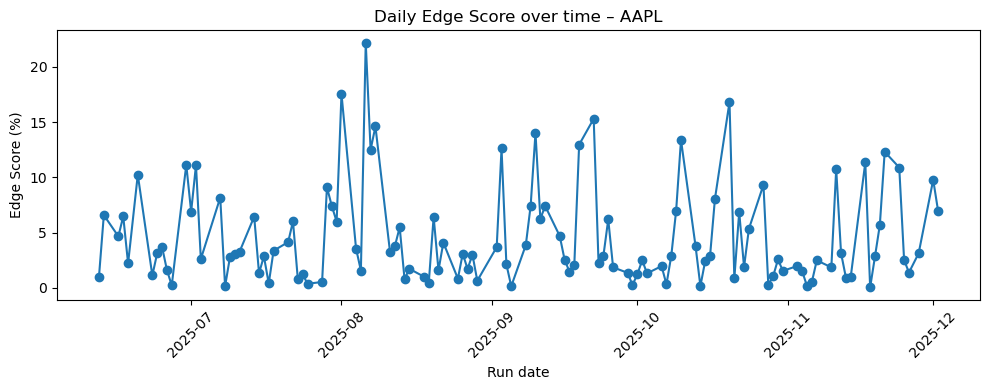

In [9]:
# Pick a sample ticker with the most rows in the window
ticker_counts = df["ticker"].value_counts()
sample_ticker = ticker_counts.index[0]

print(f"Sample ticker for history view: {sample_ticker}")

ticker_history = (
    df.loc[df["ticker"] == sample_ticker]
      .sort_values("run_date")
      [["run_date", "edge_score", "rv_20d", "day_pct"]]
)

display(ticker_history.head())

if len(ticker_history) > 1:
    plt.figure(figsize=(10, 4))
    plt.plot(ticker_history["run_date"], ticker_history["edge_score"], marker="o")
    plt.title(f"Daily Edge Score over time – {sample_ticker}")
    plt.xlabel("Run date")
    plt.ylabel("Edge Score (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough history yet to plot a time series; run the screener on more days.")

In [10]:
con.sql("""
SELECT
    COUNT(*)              AS n_rows,
    COUNT(DISTINCT ticker) AS n_tickers,
    MIN(run_date)         AS min_date,
    MAX(run_date)         AS max_date
FROM screener_snapshots
""").df()

,n_rows,n_tickers,min_date,max_date
0,1200,10,2025-06-12,2025-12-02


In [11]:
con.close()

## 9. Takeaways & next steps

**Quick conclusions:**

- The screener table is clean and flowing correctly from Notebook 00

- Edge scores behave logically

- Volatility vs Day % move validates domain intuition

- We have a usable foundation for signal engineering

**Next notebooks:**

**Notebook 02 — Feature Engineering & Signal Design**

We will:

- Convert raw features into robust signals

- Engineer volatility regimes

- Create rolling metrics

- Export engineered features to DuckDB

**Notebook 03 — Backtesting**

We will:

- Evaluate how engineered signals performed historically

- Build deterministic policies

- Prepare the table for RL (Notebook 06)